In [1]:
import scanpy as sc
import pandas as pd
import celltypist
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from celltypist import models

RANDOM_STATE = 42
RESULTS_FOLDER = 'results/'
DATA_PATH = 'data/GSE239626/MTX'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Import data

In [2]:
adata = sc.read_10x_mtx(
    DATA_PATH,
    var_names='gene_symbols',
    gex_only=False,
    cache=True)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 72317 × 36636
    var: 'gene_ids', 'feature_types'

In [3]:
adata = adata[:, adata.var['feature_types'] == 'Gene Expression']

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
adata.X

<72317x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 96626578 stored elements in Compressed Sparse Column format>

In [6]:
labels = pd.read_csv(RESULTS_FOLDER+'cluster_labels.csv')
adata.obs['leiden'] = labels['leiden']
adata

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'leiden'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

### Model

In [7]:
models.download_models(force_update=False)

📂 Storing models in C:\Users\giuli\.celltypist\data\models
⏩ Skipping [1/46]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/46]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/46]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [4/46]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [5/46]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [6/46]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [7/46]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [8/46]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [9/46]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [10/46]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [11/46]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [12/46]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [13/46]: Cells_Adult_Breast.pkl (file exists)
⏩ Skipping [14/46]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [15/46]: Cells_Human_Tonsil.pkl (file exists)
⏩ Skipping [16/46]: Cells_Intestinal_Tract

In [8]:
model_name = 'Immune_All_Low'

In [9]:
model = models.Model.load(model = model_name+'.pkl') # 'Immune_All_High'

In [10]:
display(model)
#display(model.cell_types)

CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

Detect neighborhood graph

In [11]:
clustering_labels_df = pd.read_csv(RESULTS_FOLDER+'cluster_labels.csv', index_col=0)
clustering_labels = clustering_labels_df['leiden'].values

In [12]:
clustering_score_df = pd.read_csv(RESULTS_FOLDER+'clustering_score.csv')

row = clustering_score_df[clustering_score_df['silhouette_score'] == clustering_score_df['silhouette_score'].max()]
n_neighbors = row['n_neighbors'].values[0]
resolution = row['resolution'].values[0]
pca_dim = row['pca_dim'].values[0]

sc.pp.neighbors(
    adata,
    n_neighbors=n_neighbors,
    n_pcs=pca_dim,
    knn=True,
    metric='euclidean', # 'correlation'
    random_state=RANDOM_STATE
    )

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [13]:
adata.uns['neighbors']

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'n_neighbors': 10,
  'method': 'umap',
  'random_state': 42,
  'metric': 'euclidean',
  'n_pcs': 5}}

Make predictions, finally :)

In [14]:
predictions = celltypist.annotate(
    adata,
    model = model_name+'.pkl',
    majority_voting=True,
    mode='best match'
)

🔬 Input data has 72317 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [15]:
predictions

CellTypist prediction result for 72317 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 72317 query cells and 98 cell types
    probability_matrix: data frame with 72317 query cells and 98 cell types
    adata: AnnData object referred

### Results

In [16]:
predictions.predicted_labels.head()

,predicted_labels,over_clustering,majority_voting
AAACCCAAGACTGTTC-1,Regulatory T cells,338,Tem/Trm cytotoxic T cells
AAACCCAAGGATCATA-1,Tcm/Naive cytotoxic T cells,28,Tcm/Naive cytotoxic T cells
AAACCCAGTTATTCTC-1,Memory B cells,413,Memory B cells
AAACCCATCATGAGGG-1,Tcm/Naive cytotoxic T cells,142,Tcm/Naive cytotoxic T cells
AAACGAAAGCCAGTAG-1,Transitional B cells,306,Naive B cells


In [17]:
predictions.predicted_labels.to_csv(RESULTS_FOLDER+'celltypist_labels_'+model_name+'.csv')

In [18]:
len(predictions.predicted_labels['predicted_labels'].unique())

66

In [19]:
adata.obs['predicted_labels'] = predictions.predicted_labels['predicted_labels']

... storing 'feature_types' as categorical


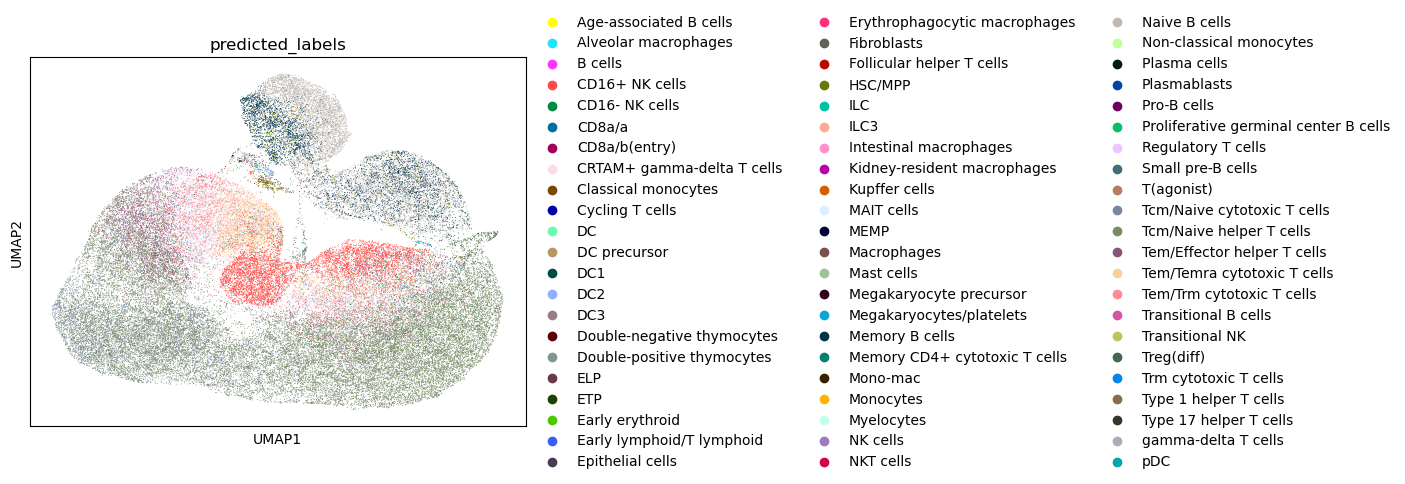

In [20]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['predicted_labels'], color_map='tab20')

In [21]:
adata.obs['predicted_labels'].value_counts()

predicted_labels
Tcm/Naive helper T cells         29669
Naive B cells                     7997
CD16+ NK cells                    6191
Tcm/Naive cytotoxic T cells       5682
Memory B cells                    4926
                                 ...  
Kupffer cells                        1
Kidney-resident macrophages          1
Intestinal macrophages               1
Mono-mac                             1
Erythrophagocytic macrophages        1
Name: count, Length: 66, dtype: int64

In [22]:
labels = adata.obs['predicted_labels'].value_counts()[adata.obs['predicted_labels'].value_counts() > 1].index
labels

CategoricalIndex(['Tcm/Naive helper T cells', 'Naive B cells',
                  'CD16+ NK cells', 'Tcm/Naive cytotoxic T cells',
                  'Memory B cells', 'Tem/Temra cytotoxic T cells',
                  'Tem/Trm cytotoxic T cells', 'Tem/Effector helper T cells',
                  'MAIT cells', 'Regulatory T cells', 'NK cells',
                  'Classical monocytes', 'Age-associated B cells',
                  'Non-classical monocytes', 'CD16- NK cells', 'DC2',
                  'CRTAM+ gamma-delta T cells', 'ILC3', 'Plasma cells',
                  'Trm cytotoxic T cells', 'pDC', 'Double-positive thymocytes',
                  'CD8a/a', 'Type 17 helper T cells', 'Alveolar macrophages',
                  'Megakaryocytes/platelets', 'Transitional B cells',
                  'HSC/MPP', 'Type 1 helper T cells',
                  'Megakaryocyte precursor', 'Plasmablasts',
                  'Follicular helper T cells', 'NKT cells', 'T(agonist)',
                  'Transitional N

In [23]:
adata = adata[adata.obs['predicted_labels'].isin(labels)]
sc.tl.rank_genes_groups(adata, groupby='predicted_labels', method='t-test')
gene_groups = adata.uns['rank_genes_groups']

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\giuli\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:434: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

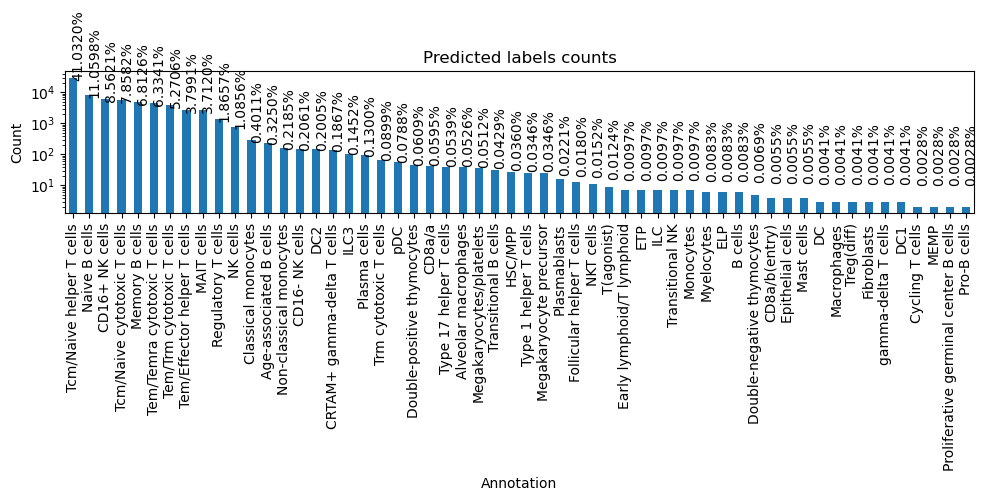

In [24]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
adata.obs['predicted_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata.obs['predicted_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Predicted labels counts')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [25]:
adata

AnnData object with n_obs × n_vars = 72307 × 36601
    obs: 'leiden', 'predicted_labels'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'neighbors', 'over_clustering', 'umap', 'predicted_labels_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [26]:
predictions.predicted_labels['predicted_labels'].unique()

['Regulatory T cells', 'Tcm/Naive cytotoxic T cells', 'Memory B cells', 'Transitional B cells', 'Naive B cells', ..., 'DC3', 'Small pre-B cells', 'Kupffer cells', 'Memory CD4+ cytotoxic T cells', 'Kidney-resident macrophages']
Length: 66
Categories (66, object): ['Age-associated B cells', 'Alveolar macrophages', 'B cells', 'CD16+ NK cells', ..., 'Type 1 helper T cells', 'Type 17 helper T cells', 'gamma-delta T cells', 'pDC']

In [35]:
markers = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers[label] = gene_groups['names'][label].tolist()[:10] # top 10 markers, for each cell type

print(markers)

{'Regulatory T cells': ['RTKN2', 'IL32', 'ITGB1', 'SAMHD1', 'SYNE2', 'NEAT1', 'S100A4', 'TRAC', 'IKZF2', 'GBP5'], 'Tcm/Naive cytotoxic T cells': ['CD8B', 'LINC02446', 'RPS2', 'RPL13', 'RPS12', 'RPS5', 'RPS6', 'RPL19', 'CD8A', 'RPS8'], 'Memory B cells': ['MS4A1', 'CD74', 'BANK1', 'HLA-DRA', 'RALGPS2', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DPB1', 'CD79A', 'TNFRSF13C'], 'Transitional B cells': ['IGHM', 'CD74', 'IGHD', 'MS4A1', 'HLA-DRA', 'JUND', 'PTMA', 'TCL1A', 'CD79B', 'HLA-DRB1'], 'Naive B cells': ['IGHM', 'CD74', 'MS4A1', 'HLA-DRA', 'HLA-DQB1', 'IGHD', 'HLA-DRB1', 'MEF2C', 'LINC00926', 'CD37'], 'CD16+ NK cells': ['GNLY', 'PRF1', 'KLRD1', 'NKG7', 'GZMB', 'SPON2', 'CD247', 'KLRF1', 'EFHD2', 'CTSW'], 'Tcm/Naive helper T cells': ['BCL11B', 'IL7R', 'FYB1', 'TCF7', 'LEF1', 'PRKCQ-AS1', 'SERINC5', 'IL6ST', 'TRABD2A', 'AAK1'], 'Tem/Effector helper T cells': ['S100A4', 'IL32', 'VIM', 'IL7R', 'ANXA1', 'LTB', 'S100A10', 'B2M', 'RPL10', 'S100A6'], 'MAIT cells': ['GZMK', 'DUSP2', 'KLRB1', 'ARL4C', 'ZFP36L2

In [36]:
with open(RESULTS_FOLDER+'celltypist_markers_'+model_name+'.json', 'w') as f:
    json.dump(markers, f)

In [49]:
markers_restricted = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers_restricted[label] = gene_groups['names'][label].tolist()[:1]

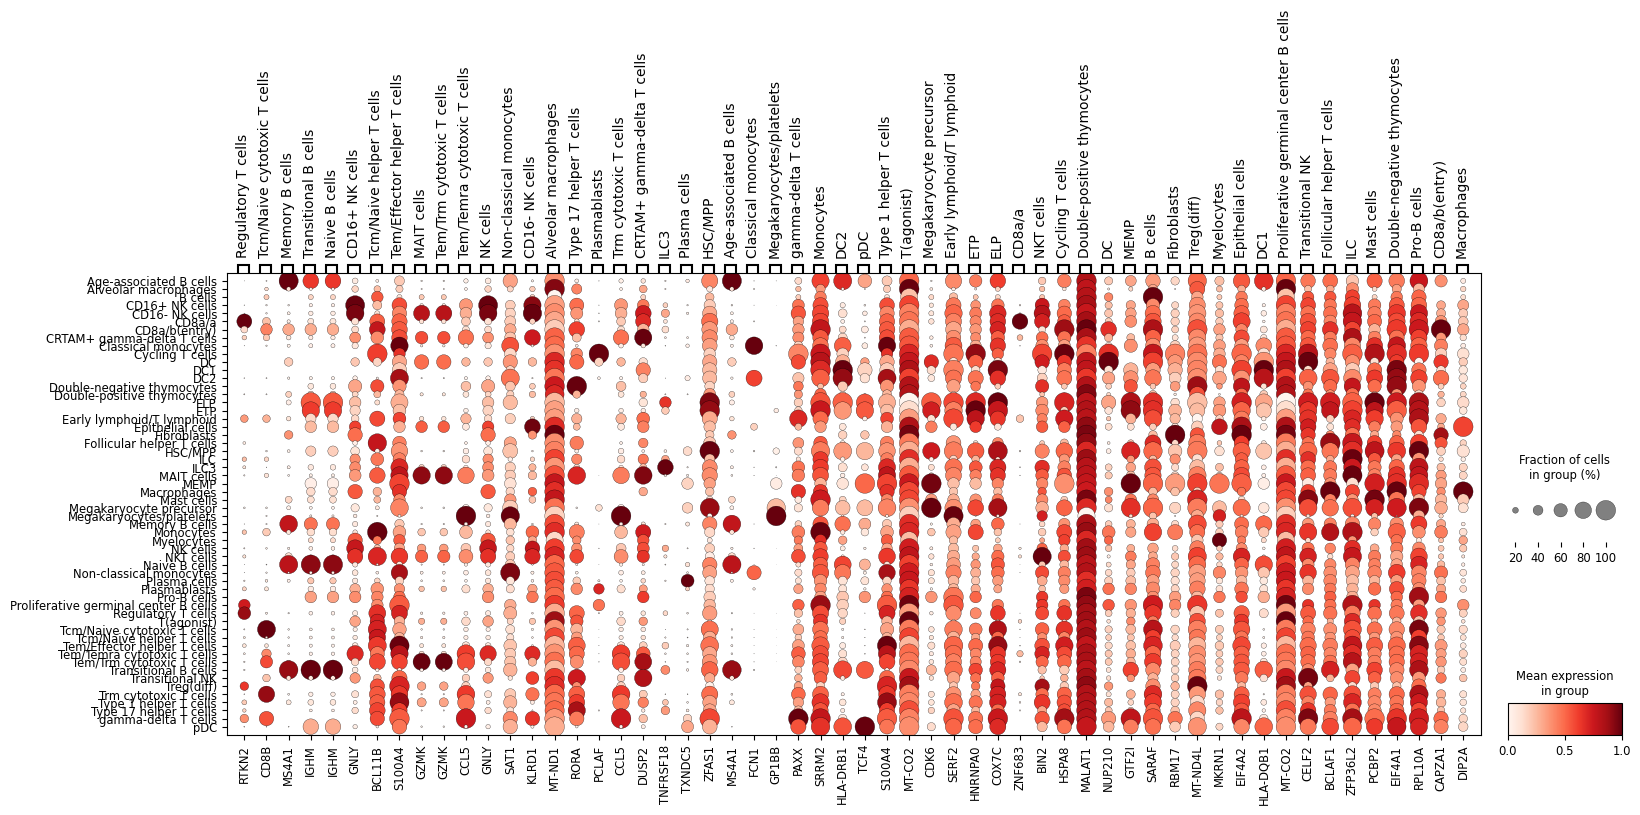

In [52]:
sc.pl.dotplot(
    adata,
    markers_restricted,
    groupby="predicted_labels",
    figsize=(18, 6),
    standard_scale='var',
)